# Non-Linear Regression Models for Abalone Age Prediction 

In [24]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.io/py" 

## Load libraries 
- Import necessary libraries for data processing, modeling, evaluation, and visualization

In [25]:
# Import necessary libraries for data processing, modeling, evaluation, and visualization
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns

## Load datasets
- Load the training, test, and sample submission datasets
- The training set contains labeled data (features + target), while the test set lacks the target.

In [26]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

## Separate predictors and targets
- Separate predictors and target variable from the training dataset
- Drop 'id' and 'Rings' to form feature matrix X, while 'Rings' is the target variable y

In [27]:
X = train.drop(columns=["id", "Rings"])
y = train["Rings"]

## Drop 'id' from test set
- Drop only 'id' from the test set to obtain the feature matrix for predictions

In [28]:
X_test = test.drop(columns=["id"])

## Identify features for preprocessing 
- Identify numerical and categorical features for preprocessing

In [29]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

## Build a ColumnTransformer for preprocessing
- Scale numeric features using StandardScaler to standardize magnitudes.
- One-hot encode categorical features (dropping the first to avoid multicollinearity).

In [30]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

## Split the data (training and validation)
- Split the data into training and validation sets to evaluate model performance
- This ensures we can compute RMSLE without accessing the test set

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## --------------------- Model 1: LassoCV ---------------------
- Create a pipeline combining preprocessing and Lasso regression with cross-validation
- LassoCV selects the best regularization strength (alpha) and performs feature selection

In [32]:
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5, random_state=42))
])

In [33]:
## Fit the Lasso pipeline on the training data

In [34]:
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Sex'], dtype='object'))])),
                ('regressor', LassoCV(cv=5, random_state=42))])

# Predict on the validation set 
- Predict on the validation set and ensure non-negative predictions (as required by RMSLE)

In [35]:
y_val_pred_lasso = np.maximum(0, lasso_pipeline.predict(X_val))

## Compute the RMSLE 
- Compute the RMSLE (Root Mean Squared Logarithmic Error) for Lasso

In [36]:
rmsle_lasso = np.sqrt(mean_squared_log_error(y_val, y_val_pred_lasso))

## Predict on the actual
- Predict on the actual test data for final submission

In [37]:
y_test_pred_lasso = np.maximum(0, lasso_pipeline.predict(X_test)).astype(int)

## --------- Model 2: Principal Components Regression (PCR) ---------
-  Apply preprocessing to the train, validation, and test sets

In [38]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

## Apply PCA (principal component analysis)
- Apply PCA (principal component analysis) to reduce dimensionality and eliminate multicollinearity
- Retain enough principal components to preserve 95% of variance

In [39]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

## Train a simple regression model 
- Train a simple linear regression model on the principal components

In [40]:
pcr_model = LinearRegression()
pcr_model.fit(X_train_pca, y_train)

LinearRegression()

## Predict on  validation 
- Predict on the validation set and clip negative values

In [41]:
y_val_pred_pcr = np.maximum(0, pcr_model.predict(X_val_pca))

## Compute the RMSLE
- Compute the RMSLE for the PCR model

In [42]:
rmsle_pcr = np.sqrt(mean_squared_log_error(y_val, y_val_pred_pcr))

## Predict on the test set 
- Predict on the actual test set for final submission

In [43]:
y_test_pred_pcr = np.maximum(0, pcr_model.predict(X_test_pca)).astype(int)

## --------------------- Output Submission Files ---------------------
- Prepare the submission DataFrames with the original test IDs and predicted Rings values

In [44]:
submission_lasso = pd.DataFrame({"id": test["id"], "Rings": y_test_pred_lasso})
submission_pcr = pd.DataFrame({"id": test["id"], "Rings": y_test_pred_pcr})

- Save both predictions to CSV files for potential Kaggle submission

In [45]:
submission_lasso_path = "submission_lasso.csv"
submission_pcr_path = "submission_pcr.csv"
submission_lasso.to_csv(submission_lasso_path, index=False)
submission_pcr.to_csv(submission_pcr_path, index=False)

## ---------------- Compare Model Performance ----------------
- Create a summary DataFrame to display RMSLE values side by side

In [46]:
results_df = pd.DataFrame({
    "Model": ["Lasso", "PCR"],
    "RMSLE": [rmsle_lasso, rmsle_pcr]
})
print(results_df)

   Model     RMSLE
0  Lasso  0.166694
1    PCR  0.188671


## --------------------- Visual Diagnostics ---------------------
- Create diagnostic plots to assess residual behavior for both models.
- Residuals help us evaluate model bias, variance, and systematic errors.
1. Compute residuals (actual - predicted) for the validation set.
1. Set up a 2x2 grid of plots to show residual patterns for both models.
1. LassoCV: Residuals vs Fitted plot. Helps detect non-linearity, heteroscedasticity, or other patterns in errors. 
1. LassoCV: Histogram of residuals. Checks for approximate normality and spread of residuals.
1. PCR: Residuals vs Fitted plot 
1. PCR: Histogram of residuals 
1. Improve spacing between subplots

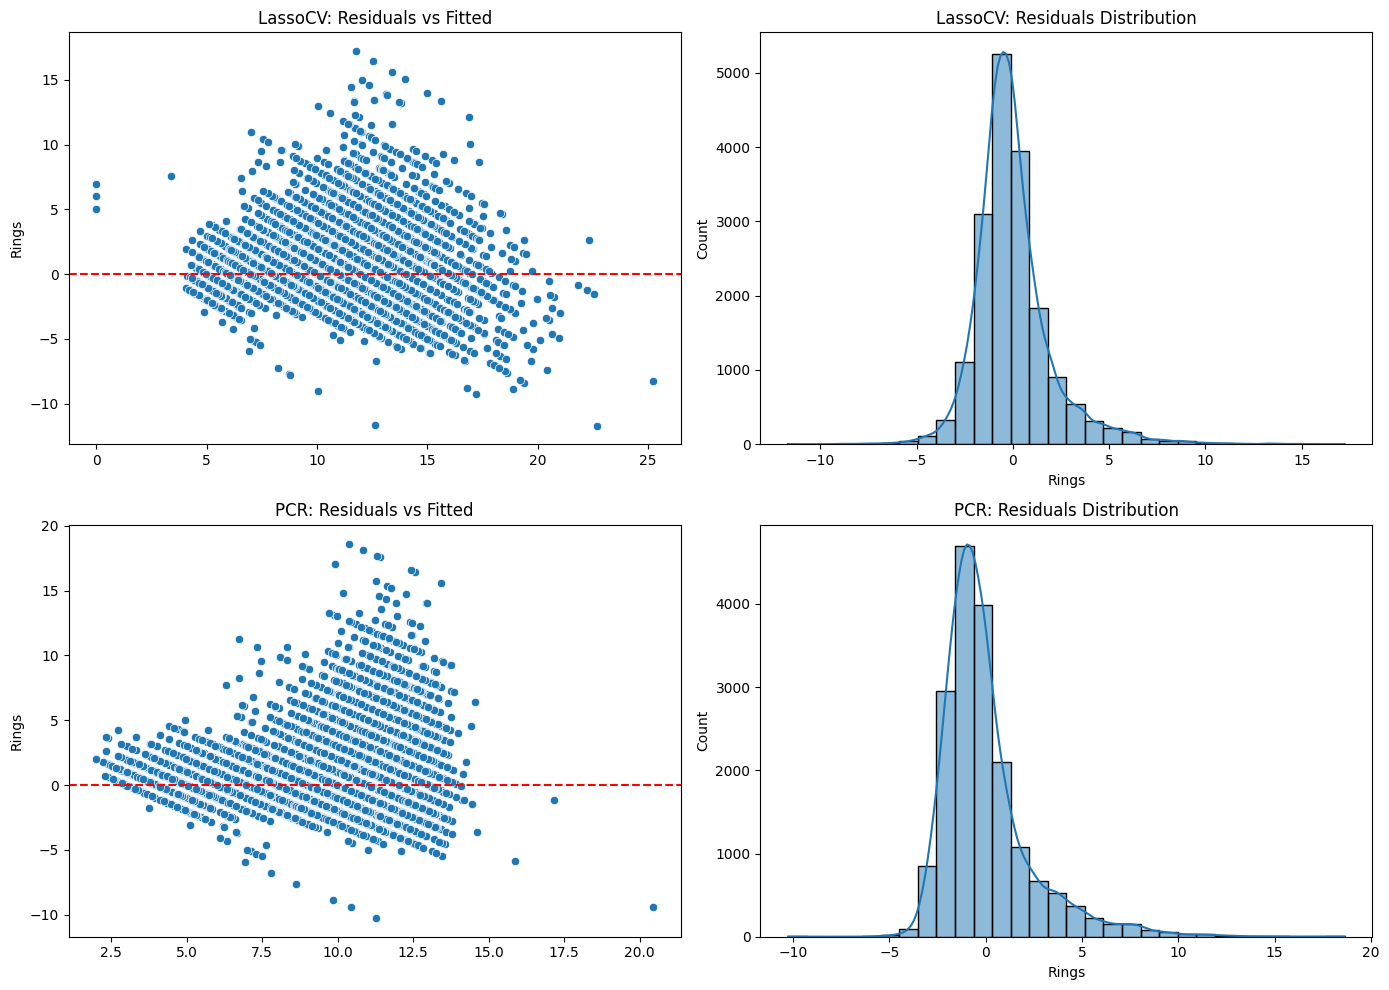

In [47]:
# Compute residuals (actual - predicted) for the validation set
lasso_residuals = y_val - y_val_pred_lasso
pcr_residuals = y_val - y_val_pred_pcr 

# Set up a 2x2 grid of plots to show residual patterns for both models
fig, axs = plt.subplots(2, 2, figsize=(14, 10)) 

# LassoCV: Residuals vs Fitted plot
# Helps detect non-linearity, heteroscedasticity, or other patterns in errors
sns.scatterplot(x=y_val_pred_lasso, y=lasso_residuals, ax=axs[0, 0])
axs[0, 0].axhline(0, linestyle='--', color='red')
axs[0, 0].set_title("LassoCV: Residuals vs Fitted") 

# LassoCV: Histogram of residuals
# Checks for approximate normality and spread of residuals
sns.histplot(lasso_residuals, bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title("LassoCV: Residuals Distribution") 

# PCR: Residuals vs Fitted plot
sns.scatterplot(x=y_val_pred_pcr, y=pcr_residuals, ax=axs[1, 0])
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("PCR: Residuals vs Fitted")

# PCR: Histogram of residuals
sns.histplot(pcr_residuals, bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title("PCR: Residuals Distribution") 

# Improve spacing between subplots
plt.tight_layout()
plt.show()

## Final outputs
-  Output the final submission paths (for reference or logging)

In [48]:
submission_lasso_path, submission_pcr_path

('submission_lasso.csv', 'submission_pcr.csv')